Classification Using Simple RNN + Other Layers

#Importing

In [ ]:
# For DataFrame
import pandas as pd

# Matplot & Seaborn for Visualizing the analysis of the data.
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.ticker import MaxNLocator
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches

import seaborn as sns

In [ ]:
# Scikit-learn for data analysis
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
import sklearn.metrics as metrics
from sklearn.manifold import TSNE
from sklearn.metrics import plot_confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.metrics import (
    precision_score, 
    recall_score, 
    f1_score, 
    classification_report,
    accuracy_score
)

In [ ]:
# Keras, this library helps with neural network connections
import tensorflow 
import tensorflow as tf#used for debugging.
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences#Debugged an error.
from keras.models import Sequential
from keras.layers import (LSTM, 
                          SimpleRNN,
                          Activation,
                          Conv1D,
                          MaxPooling1D,
                          Embedding, 
                          BatchNormalization,
                          Dense, 
                          TimeDistributed, 
                          Dropout, 
                          Bidirectional,
                          Flatten, 
                          GlobalMaxPool1D)
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.layers import Embedding
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.initializers import Constant
from tensorflow.keras import optimizers

In [ ]:
# nltk, this library helps us to process the human language i.e., tweets in this case.
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
import nltk
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
#Extra imports based on suggestions
# Word2vec
import gensim
from gensim.test.utils import common_texts
from gensim.models import Word2Vec

# Utility
import string
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools
import random
import datetime

# WordCloud
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from collections import Counter, defaultdict

# Warnings
import warnings 
warnings.filterwarnings('ignore')

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)


In [ ]:
#importing  test dataset into train.
train = pd.read_csv("/content/train.csv")
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
#importing Test Dataset onto test

test = pd.read_csv("/content/test.csv")
test.head()


,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [ ]:
# Checking Submission Dataset
#urop
sub = pd.read_csv("/content/submission.csv")
sub.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


#Preprocessing

In [ ]:
# Collating both train and test datasets for data pre-processing 
df_train_uptd = train.drop("target", axis = 1)

# Combing both test and train datasets for merged dataset creation
# Here data schema betwee the two datases are exactly similar. Hence we can use concat() to merge rows

df = pd.concat([df_train_uptd,test], axis = 0, ignore_index= True)
print("Total rows present = ", len(df))
df.head(5)

Total rows present =  10876


,id,keyword,location,text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...


Text(0.5, 1.0, 'Sentiment Distribution')

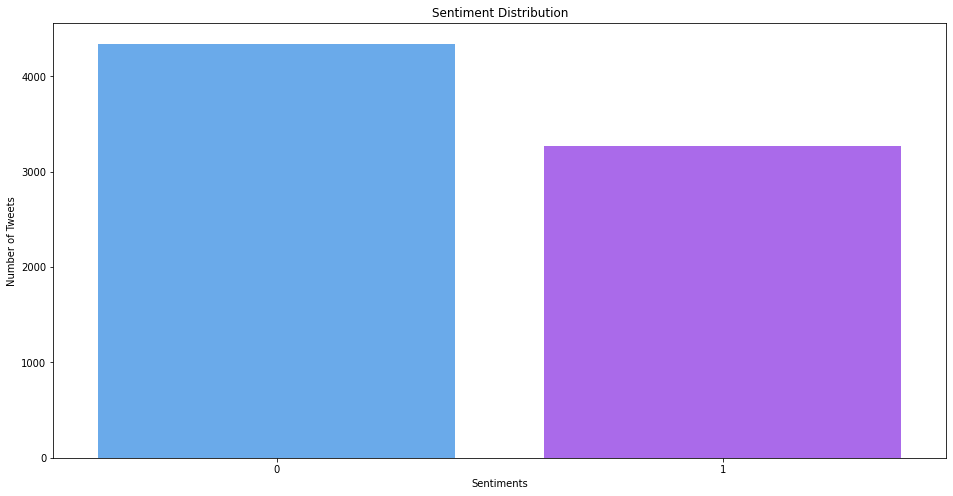

In [ ]:
#Here just we have visualized the data sets using a function from matplt.lib
plt.figure(figsize=(16,8))
x = train.target.value_counts()
# color = ["#494623","8e883d"]

# customPalette = sns.set_palette(sns.color_palette(color))
sns.barplot(x.index, x, palette="cool")

plt.gca().set_ylabel('Number of Tweets')
plt.gca().set_xlabel('Sentiments')
plt.title("Sentiment Distribution")

In [ ]:
# urop
# In this we are deciding what should be the stop words and what are not to be considered as stop words
stop_words = set(stopwords.words("english"))
stop_words.remove('not')
more_stopwords = {'one', 'br', 'Po', 'th', 'sayi', 'fo', 'Unknown'}
stop_words = stop_words.union(more_stopwords)                
stemmer = SnowballStemmer("english")


In [ ]:
#In the process of preprocessing we call this function for removing URLs in the data
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')#refered from prepinsta
    return url.sub(r'', text)

In [ ]:
#In the process of preprocessing we call this function for removing Emojis in the tweets data.
def remove_emoji(text):
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags 
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)


In [ ]:
#In the process of preprocessing we call this function for removing inner html links #urop
def remove_html(text):
    html = re.compile(r'^[^ ]<.#*?>|&([a-z0-9]+|#[0-9]\"\'\“{1,6}|#x[0-9a-f]{1,6});[^A-Za-z0-9]+') # '#' was added specially by me to remove hashtags. 
    return re.sub(html, '', text)


In [ ]:
#In the process of preprocessing we call this function for removing punctuations
def remove_punct(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)


In [ ]:
#In the process of preprocessing we call this function for removing quotes.
def remove_quotes(text):
    quotes = re.compile(r'[^A-Za-z0-9\s]+')
    return re.sub(quotes, '', text)

In [ ]:
# Applying helper functions on the data frame choosen.

df['mod_text'] = df['text'].apply(lambda x: remove_URL(x))
df['mod_text'] = df['mod_text'].apply(lambda x: remove_emoji(x))
df['mod_text'] = df['mod_text'].apply(lambda x: remove_html(x))
df['mod_text'] = df['mod_text'].apply(lambda x: remove_punct(x))
df['mod_text'] = df['mod_text'].apply(lambda x: remove_quotes(x))
df.head() #just to the sample #urop

,id,keyword,location,text,mod_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,Our Deeds are the Reason of this earthquake Ma...
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,Forest fire near La Ronge Sask Canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,All residents asked to shelter in place are be...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",13000 people receive wildfires evacuation orde...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,Just got sent this photo from Ruby Alaska as s...


In [ ]:
# In this we have tokenized the tweet data further.

df['tokenized'] = df['mod_text'].apply(word_tokenize)

df.head()

,id,keyword,location,text,mod_text,tokenized
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,Our Deeds are the Reason of this earthquake Ma...,"[Our, Deeds, are, the, Reason, of, this, earth..."
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,Forest fire near La Ronge Sask Canada,"[Forest, fire, near, La, Ronge, Sask, Canada]"
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,All residents asked to shelter in place are be...,"[All, residents, asked, to, shelter, in, place..."
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",13000 people receive wildfires evacuation orde...,"[13000, people, receive, wildfires, evacuation..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,Just got sent this photo from Ruby Alaska as s...,"[Just, got, sent, this, photo, from, Ruby, Ala..."


In [ ]:
# Here we have lowered all the text so that it is easy to proccess further
df['lower'] = df['tokenized'].apply(
    lambda x: [word.lower() for word in x])
df.head()

,id,keyword,location,text,mod_text,tokenized,lower
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,Our Deeds are the Reason of this earthquake Ma...,"[Our, Deeds, are, the, Reason, of, this, earth...","[our, deeds, are, the, reason, of, this, earth..."
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,Forest fire near La Ronge Sask Canada,"[Forest, fire, near, La, Ronge, Sask, Canada]","[forest, fire, near, la, ronge, sask, canada]"
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,All residents asked to shelter in place are be...,"[All, residents, asked, to, shelter, in, place...","[all, residents, asked, to, shelter, in, place..."
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",13000 people receive wildfires evacuation orde...,"[13000, people, receive, wildfires, evacuation...","[13000, people, receive, wildfires, evacuation..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,Just got sent this photo from Ruby Alaska as s...,"[Just, got, sent, this, photo, from, Ruby, Ala...","[just, got, sent, this, photo, from, ruby, ala..."


In [ ]:
# In  this we will remove stop words that we defined prior, this time it is useless words, prepositions.
#UROP
#Used standard stop words that were mentioned in "Socket" API 
df['stopwords_removed'] = df['lower'].apply(
    lambda x: [word for word in x if word not in stop_words])
df.head()
#here we can see that size of text is decreasing & it will be easy to proccess.

,id,keyword,location,text,mod_text,tokenized,lower,stopwords_removed
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,Our Deeds are the Reason of this earthquake Ma...,"[Our, Deeds, are, the, Reason, of, this, earth...","[our, deeds, are, the, reason, of, this, earth...","[deeds, reason, earthquake, may, allah, forgiv..."
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,Forest fire near La Ronge Sask Canada,"[Forest, fire, near, La, Ronge, Sask, Canada]","[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, ronge, sask, canada]"
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,All residents asked to shelter in place are be...,"[All, residents, asked, to, shelter, in, place...","[all, residents, asked, to, shelter, in, place...","[residents, asked, shelter, place, notified, o..."
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",13000 people receive wildfires evacuation orde...,"[13000, people, receive, wildfires, evacuation...","[13000, people, receive, wildfires, evacuation...","[13000, people, receive, wildfires, evacuation..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,Just got sent this photo from Ruby Alaska as s...,"[Just, got, sent, this, photo, from, Ruby, Ala...","[just, got, sent, this, photo, from, ruby, ala...","[got, sent, photo, ruby, alaska, smoke, wildfi..."


In [ ]:
# Applying part of speech tags.

#Here we add tags for each token what type of POS it is, using nltk std. function!
df['pos_tags'] = df['stopwords_removed'].apply(nltk.tag.pos_tag)

df.head()#for sample

,id,keyword,location,text,mod_text,tokenized,lower,stopwords_removed,pos_tags
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,Our Deeds are the Reason of this earthquake Ma...,"[Our, Deeds, are, the, Reason, of, this, earth...","[our, deeds, are, the, reason, of, this, earth...","[deeds, reason, earthquake, may, allah, forgiv...","[(deeds, NNS), (reason, NN), (earthquake, NN),..."
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,Forest fire near La Ronge Sask Canada,"[Forest, fire, near, La, Ronge, Sask, Canada]","[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, ronge, sask, canada]","[(forest, JJS), (fire, NN), (near, IN), (la, J..."
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,All residents asked to shelter in place are be...,"[All, residents, asked, to, shelter, in, place...","[all, residents, asked, to, shelter, in, place...","[residents, asked, shelter, place, notified, o...","[(residents, NNS), (asked, VBD), (shelter, JJ)..."
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",13000 people receive wildfires evacuation orde...,"[13000, people, receive, wildfires, evacuation...","[13000, people, receive, wildfires, evacuation...","[13000, people, receive, wildfires, evacuation...","[(13000, CD), (people, NNS), (receive, JJ), (w..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,Just got sent this photo from Ruby Alaska as s...,"[Just, got, sent, this, photo, from, Ruby, Ala...","[just, got, sent, this, photo, from, ruby, ala...","[got, sent, photo, ruby, alaska, smoke, wildfi...","[(got, VBD), (sent, JJ), (photo, NN), (ruby, N..."


In [ ]:
#for re labeling the POS.

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN


df['wordnet_pos'] = df['pos_tags'].apply(
    lambda x: [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in x])

df.head()

,id,keyword,location,text,mod_text,tokenized,lower,stopwords_removed,pos_tags,wordnet_pos
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,Our Deeds are the Reason of this earthquake Ma...,"[Our, Deeds, are, the, Reason, of, this, earth...","[our, deeds, are, the, reason, of, this, earth...","[deeds, reason, earthquake, may, allah, forgiv...","[(deeds, NNS), (reason, NN), (earthquake, NN),...","[(deeds, n), (reason, n), (earthquake, n), (ma..."
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,Forest fire near La Ronge Sask Canada,"[Forest, fire, near, La, Ronge, Sask, Canada]","[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, ronge, sask, canada]","[(forest, JJS), (fire, NN), (near, IN), (la, J...","[(forest, a), (fire, n), (near, n), (la, a), (..."
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,All residents asked to shelter in place are be...,"[All, residents, asked, to, shelter, in, place...","[all, residents, asked, to, shelter, in, place...","[residents, asked, shelter, place, notified, o...","[(residents, NNS), (asked, VBD), (shelter, JJ)...","[(residents, n), (asked, v), (shelter, a), (pl..."
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",13000 people receive wildfires evacuation orde...,"[13000, people, receive, wildfires, evacuation...","[13000, people, receive, wildfires, evacuation...","[13000, people, receive, wildfires, evacuation...","[(13000, CD), (people, NNS), (receive, JJ), (w...","[(13000, n), (people, n), (receive, a), (wildf..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,Just got sent this photo from Ruby Alaska as s...,"[Just, got, sent, this, photo, from, Ruby, Ala...","[just, got, sent, this, photo, from, ruby, ala...","[got, sent, photo, ruby, alaska, smoke, wildfi...","[(got, VBD), (sent, JJ), (photo, NN), (ruby, N...","[(got, v), (sent, a), (photo, n), (ruby, n), (..."


In [ ]:
# Applying word lemmatizer.

# By applying this we have joined back the sentance again with correct phrasing of words. We call it as Lemmitizing.
wnl = WordNetLemmatizer()

df['lemmatized'] = df['wordnet_pos'].apply(
    lambda x: [wnl.lemmatize(word, tag) for word, tag in x])

df['lemmatized'] = df['lemmatized'].apply(
    lambda x: [word for word in x if word not in stop_words])

df['lemma_str'] = [' '.join(map(str, l)) for l in df['lemmatized']]

df.head()

,id,keyword,location,text,mod_text,tokenized,lower,stopwords_removed,pos_tags,wordnet_pos,lemmatized,lemma_str
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,Our Deeds are the Reason of this earthquake Ma...,"[Our, Deeds, are, the, Reason, of, this, earth...","[our, deeds, are, the, reason, of, this, earth...","[deeds, reason, earthquake, may, allah, forgiv...","[(deeds, NNS), (reason, NN), (earthquake, NN),...","[(deeds, n), (reason, n), (earthquake, n), (ma...","[deed, reason, earthquake, may, allah, forgive...",deed reason earthquake may allah forgive u
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,Forest fire near La Ronge Sask Canada,"[Forest, fire, near, La, Ronge, Sask, Canada]","[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, ronge, sask, canada]","[(forest, JJS), (fire, NN), (near, IN), (la, J...","[(forest, a), (fire, n), (near, n), (la, a), (...","[forest, fire, near, la, ronge, sask, canada]",forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,All residents asked to shelter in place are be...,"[All, residents, asked, to, shelter, in, place...","[all, residents, asked, to, shelter, in, place...","[residents, asked, shelter, place, notified, o...","[(residents, NNS), (asked, VBD), (shelter, JJ)...","[(residents, n), (asked, v), (shelter, a), (pl...","[resident, ask, shelter, place, notify, office...",resident ask shelter place notify officer evac...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",13000 people receive wildfires evacuation orde...,"[13000, people, receive, wildfires, evacuation...","[13000, people, receive, wildfires, evacuation...","[13000, people, receive, wildfires, evacuation...","[(13000, CD), (people, NNS), (receive, JJ), (w...","[(13000, n), (people, n), (receive, a), (wildf...","[13000, people, receive, wildfire, evacuation,...",13000 people receive wildfire evacuation order...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,Just got sent this photo from Ruby Alaska as s...,"[Just, got, sent, this, photo, from, Ruby, Ala...","[just, got, sent, this, photo, from, ruby, ala...","[got, sent, photo, ruby, alaska, smoke, wildfi...","[(got, VBD), (sent, JJ), (photo, NN), (ruby, N...","[(got, v), (sent, a), (photo, n), (ruby, n), (...","[get, sent, photo, ruby, alaska, smoke, wildfi...",get sent photo ruby alaska smoke wildfires pou...


In [ ]:
#we are checking whether the whole tuples remains same or not after all preprocessors.
print("Total Rows :", len(df.lemmatized))

Total Rows : 10876


In [ ]:
df_final = df[["lemma_str", "id"]]
df_final.head()

,lemma_str,id
0,deed reason earthquake may allah forgive u,1
1,forest fire near la ronge sask canada,4
2,resident ask shelter place notify officer evac...,5
3,13000 people receive wildfire evacuation order...,6
4,get sent photo ruby alaska smoke wildfires pou...,7


In [ ]:
treated_train = pd.merge(train, df_final, on='id')
treated_train.tail()

,id,keyword,location,text,target,lemma_str
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1,two giant crane hold bridge collapse nearby home
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1,ariaahrary thetawniest control wild fire calif...
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,m194 0104 utc5km volcano hawaii
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1,police investigate ebike collide car little po...
7612,10873,NaN,NaN,The Latest: More Homes Razed by Northern Calif...,1,late home raze northern california wildfire ab...


In [ ]:
#we just re-assign training data into y
y = treated_train['target']

In [ ]:

treated_test = pd.merge(test, df_final, on='id')
treated_test.tail()

,id,keyword,location,text,lemma_str
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,earthquake safety los angeles safety fastener ...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...,storm ri bad last hurricane cityamp3others har...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...,green line derailment chicago
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...,meg issue hazardous weather outlook hwo
3262,10875,NaN,NaN,#CityofCalgary has activated its Municipal Eme...,cityofcalgary activate municipal emergency pla...


In [ ]:
max_features=3000
tokenizer=Tokenizer(num_words=max_features,split=' ')
tokenizer.fit_on_texts(treated_train['lemma_str'].values)
X = tokenizer.texts_to_sequences(treated_train['lemma_str'].values)
X = pad_sequences(X)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state =41)

Layers without LSTM

In [ ]:
# #vocab_size=6025
# embed_dim = 32
# lstm_out = 32
# model = Sequential()
# model.add(Embedding(max_features, embed_dim,input_length = X.shape[1]))
# model.add(Flatten())
# model.add(Dense(1,activation='sigmoid'))
# adam = optimizers.Adam(learning_rate=0.002)
# model.compile(loss = 'binary_crossentropy', optimizer=adam ,metrics = ['accuracy'])
# print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 32)            96000     
                                                                 
 flatten (Flatten)           (None, 640)               0         
                                                                 
 dense (Dense)               (None, 1)                 641       
                                                                 
Total params: 96,641
Trainable params: 96,641
Non-trainable params: 0
_________________________________________________________________
None


Sample Trail on Simple RNN

In [ ]:
# inputs = np.random.random([32, 10, 8]).astype(np.float32)
# simple_rnn = tf.keras.layers.SimpleRNN(4)

# output = simple_rnn(inputs)  # The output has shape `[32, 4]`.

# simple_rnn = tf.keras.layers.SimpleRNN(
#     4, return_sequences=True, return_state=True)

# # whole_sequence_output has shape `[32, 10, 4]`.
# # final_state has shape `[32, 4]`.
# whole_sequence_output, final_state = simple_rnn(inputs)
# # whole_sequence_output
# final_state

<tf.Tensor: shape=(32, 4), dtype=float32, numpy=
array([[-0.32184625,  0.80278563, -0.24517645, -0.4240723 ],
       [-0.16158892,  0.82205   ,  0.02292356, -0.48777837],
       [-0.09911595,  0.83188415,  0.49352944, -0.5175988 ],
       [-0.57295567,  0.47282404, -0.37257987, -0.6263832 ],
       [ 0.07138914,  0.86188143,  0.5517192 , -0.8473247 ],
       [-0.06209403,  0.78374815,  0.58158034, -0.09519731],
       [ 0.13693348,  0.63435805,  0.62651604, -0.7214921 ],
       [-0.67477095,  0.53132355,  0.05122755, -0.6074461 ],
       [ 0.4144854 ,  0.902968  , -0.23526505, -0.55829406],
       [-0.70160425,  0.4110427 ,  0.19591613, -0.86596906],
       [-0.17473353,  0.9573702 ,  0.17040297, -0.4546084 ],
       [ 0.02685415,  0.87668675,  0.70510346, -0.46253175],
       [-0.4268954 ,  0.9122616 ,  0.41474655, -0.7564347 ],
       [-0.03267426,  0.8064707 , -0.32295746,  0.14765592],
       [ 0.7906179 ,  0.82095975,  0.15220092, -0.8189041 ],
       [-0.11150838,  0.90177226,  0

#Model

In [ ]:
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'

In [ ]:
# Initiating callbacks

callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

Simple RNN with Layers + Filters

In [ ]:
vocab_size=6025
embedding_dim = 32
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim,
                             input_length=X.shape[1]),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(10, activation='sigmoid'),
    tf.keras.layers.Dense(1, activation='sigmoid')
]) 
adam = optimizers.Adam(learning_rate=0.002)
model.compile(loss = 'binary_crossentropy', optimizer=adam ,metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 32)            192800    
                                                                 
 simple_rnn (SimpleRNN)      (None, 32)                2080      
                                                                 
 dense (Dense)               (None, 10)                330       
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 195,221
Trainable params: 195,221
Non-trainable params: 0
_________________________________________________________________


In [ ]:
callbacks_list = [
EarlyStopping(
monitor='get_f1',
patience=1,
),
ModelCheckpoint(filepath='./embd.h5',monitor='val_loss',save_best_only=True)
]

In [ ]:
history = model.fit(X_train, y_train, epochs = 100, batch_size=32, validation_split=0.2, callbacks= [callbacks])

Epoch 1/100
132/134 [============================>.] - ETA: 0s - loss: 0.6249 - accuracy: 0.6484

134/134 [==============================] - 2s 8ms/step - loss: 0.6231 - accuracy: 0.6502 - val_loss: 0.4867 - val_accuracy: 0.7899 - lr: 0.0020
Epoch 2/100
126/134 [===========================>..] - ETA: 0s - loss: 0.3820 - accuracy: 0.8457

134/134 [==============================] - 1s 7ms/step - loss: 0.3800 - accuracy: 0.8461 - val_loss: 0.5011 - val_accuracy: 0.7692 - lr: 0.0020
Epoch 3/100
130/134 [============================>.] - ETA: 0s - loss: 0.2208 - accuracy: 0.9276

134/134 [==============================] - 1s 7ms/step - loss: 0.2216 - accuracy: 0.9278 - val_loss: 0.6982 - val_accuracy: 0.6698 - lr: 0.0020
Epoch 4/100
130/134 [============================>.] - ETA: 0s - loss: 0.1401 - accuracy: 0.9637

134/134 [==============================] - 1s 7ms/step - loss: 0.1396 - accuracy: 0.9636 - val_loss: 0.6778 - val_accuracy: 0.7411 - lr: 0.0020
Epoch 5/100
129/134 [===========================>..] - ETA: 0s - loss: 0.1093 - accuracy: 0.9712

134/134 [==============================] - 1s 7ms/step - loss: 0.1090 - accuracy: 0.9716 - val_loss: 0.7394 - val_accuracy: 0.7392 - lr: 0.0020
Epoch 6/100
134/134 [==============================] - ETA: 0s - loss: 0.0959 - accuracy: 0.9751

134/134 [==============================] - 1s 7ms/step - loss: 0.0959 - accuracy: 0.9751 - val_loss: 0.7718 - val_accuracy: 0.7186 - lr: 0.0020
Epoch 7/100
127/134 [===========================>..] - ETA: 0s - loss: 0.0702 - accuracy: 0.9801

134/134 [==============================] - 1s 7ms/step - loss: 0.0718 - accuracy: 0.9798 - val_loss: 0.7666 - val_accuracy: 0.7270 - lr: 2.0000e-04
Epoch 8/100
130/134 [============================>.] - ETA: 0s - loss: 0.0670 - accuracy: 0.9815

134/134 [==============================] - 1s 7ms/step - loss: 0.0662 - accuracy: 0.9817 - val_loss: 0.7715 - val_accuracy: 0.7298 - lr: 2.0000e-04
Epoch 9/100
134/134 [==============================] - ETA: 0s - loss: 0.0644 - accuracy: 0.9805

134/134 [==============================] - 1s 7ms/step - loss: 0.0644 - accuracy: 0.9805 - val_loss: 0.7823 - val_accuracy: 0.7280 - lr: 2.0000e-04
Epoch 10/100
126/134 [===========================>..] - ETA: 0s - loss: 0.0608 - accuracy: 0.9816

134/134 [==============================] - 1s 7ms/step - loss: 0.0618 - accuracy: 0.9812 - val_loss: 0.7879 - val_accuracy: 0.7270 - lr: 2.0000e-04
Epoch 11/100
134/134 [==============================] - ETA: 0s - loss: 0.0596 - accuracy: 0.9817

134/134 [==============================] - 1s 7ms/step - loss: 0.0596 - accuracy: 0.9817 - val_loss: 0.7990 - val_accuracy: 0.7261 - lr: 2.0000e-04
Epoch 12/100
132/134 [============================>.] - ETA: 0s - loss: 0.0553 - accuracy: 0.9839

134/134 [==============================] - 1s 7ms/step - loss: 0.0551 - accuracy: 0.9840 - val_loss: 0.8006 - val_accuracy: 0.7251 - lr: 2.0000e-05
Epoch 13/100
130/134 [============================>.] - ETA: 0s - loss: 0.0538 - accuracy: 0.9853

134/134 [==============================] - 1s 7ms/step - loss: 0.0549 - accuracy: 0.9843 - val_loss: 0.8012 - val_accuracy: 0.7251 - lr: 2.0000e-05
Epoch 14/100
131/134 [============================>.] - ETA: 0s - loss: 0.0545 - accuracy: 0.9843

134/134 [==============================] - 1s 7ms/step - loss: 0.0547 - accuracy: 0.9840 - val_loss: 0.8028 - val_accuracy: 0.7251 - lr: 2.0000e-05
Epoch 15/100
131/134 [============================>.] - ETA: 0s - loss: 0.0550 - accuracy: 0.9838

134/134 [==============================] - 1s 7ms/step - loss: 0.0545 - accuracy: 0.9840 - val_loss: 0.8040 - val_accuracy: 0.7233 - lr: 2.0000e-05
Epoch 16/100
130/134 [============================>.] - ETA: 0s - loss: 0.0544 - accuracy: 0.9841

134/134 [==============================] - 1s 7ms/step - loss: 0.0542 - accuracy: 0.9840 - val_loss: 0.8047 - val_accuracy: 0.7242 - lr: 2.0000e-05
Epoch 17/100
132/134 [============================>.] - ETA: 0s - loss: 0.0541 - accuracy: 0.9841

134/134 [==============================] - 1s 7ms/step - loss: 0.0538 - accuracy: 0.9843 - val_loss: 0.8048 - val_accuracy: 0.7242 - lr: 2.0000e-06
Epoch 18/100
133/134 [============================>.] - ETA: 0s - loss: 0.0538 - accuracy: 0.9843

134/134 [==============================] - 1s 7ms/step - loss: 0.0538 - accuracy: 0.9843 - val_loss: 0.8049 - val_accuracy: 0.7242 - lr: 2.0000e-06
Epoch 19/100
128/134 [===========================>..] - ETA: 0s - loss: 0.0539 - accuracy: 0.9841

134/134 [==============================] - 1s 6ms/step - loss: 0.0537 - accuracy: 0.9843 - val_loss: 0.8050 - val_accuracy: 0.7242 - lr: 2.0000e-06
Epoch 20/100
127/134 [===========================>..] - ETA: 0s - loss: 0.0538 - accuracy: 0.9847

134/134 [==============================] - 1s 6ms/step - loss: 0.0537 - accuracy: 0.9843 - val_loss: 0.8051 - val_accuracy: 0.7242 - lr: 2.0000e-06
Epoch 21/100
130/134 [============================>.] - ETA: 0s - loss: 0.0541 - accuracy: 0.9844

134/134 [==============================] - 1s 7ms/step - loss: 0.0537 - accuracy: 0.9843 - val_loss: 0.8053 - val_accuracy: 0.7242 - lr: 2.0000e-06
Epoch 22/100
128/134 [===========================>..] - ETA: 0s - loss: 0.0545 - accuracy: 0.9839

134/134 [==============================] - 1s 6ms/step - loss: 0.0537 - accuracy: 0.9843 - val_loss: 0.8053 - val_accuracy: 0.7242 - lr: 2.0000e-07
Epoch 23/100
127/134 [===========================>..] - ETA: 0s - loss: 0.0535 - accuracy: 0.9840

134/134 [==============================] - 1s 6ms/step - loss: 0.0537 - accuracy: 0.9843 - val_loss: 0.8053 - val_accuracy: 0.7242 - lr: 2.0000e-07
Epoch 24/100
129/134 [===========================>..] - ETA: 0s - loss: 0.0535 - accuracy: 0.9840

134/134 [==============================] - 1s 7ms/step - loss: 0.0537 - accuracy: 0.9843 - val_loss: 0.8053 - val_accuracy: 0.7242 - lr: 2.0000e-07
Epoch 25/100
131/134 [============================>.] - ETA: 0s - loss: 0.0542 - accuracy: 0.9840

134/134 [==============================] - 1s 7ms/step - loss: 0.0536 - accuracy: 0.9843 - val_loss: 0.8054 - val_accuracy: 0.7242 - lr: 2.0000e-07
Epoch 26/100
133/134 [============================>.] - ETA: 0s - loss: 0.0537 - accuracy: 0.9843

134/134 [==============================] - 1s 7ms/step - loss: 0.0536 - accuracy: 0.9843 - val_loss: 0.8054 - val_accuracy: 0.7242 - lr: 2.0000e-07
Epoch 27/100
125/134 [==========================>...] - ETA: 0s - loss: 0.0550 - accuracy: 0.9837

134/134 [==============================] - 1s 6ms/step - loss: 0.0536 - accuracy: 0.9843 - val_loss: 0.8054 - val_accuracy: 0.7242 - lr: 2.0000e-08
Epoch 28/100
127/134 [===========================>..] - ETA: 0s - loss: 0.0543 - accuracy: 0.9843

134/134 [==============================] - 1s 6ms/step - loss: 0.0536 - accuracy: 0.9843 - val_loss: 0.8054 - val_accuracy: 0.7242 - lr: 2.0000e-08
Epoch 29/100
134/134 [==============================] - ETA: 0s - loss: 0.0536 - accuracy: 0.9843

134/134 [==============================] - 1s 7ms/step - loss: 0.0536 - accuracy: 0.9843 - val_loss: 0.8054 - val_accuracy: 0.7242 - lr: 2.0000e-08
Epoch 30/100
134/134 [==============================] - ETA: 0s - loss: 0.0536 - accuracy: 0.9843

134/134 [==============================] - 1s 7ms/step - loss: 0.0536 - accuracy: 0.9843 - val_loss: 0.8054 - val_accuracy: 0.7242 - lr: 2.0000e-08
Epoch 31/100
126/134 [===========================>..] - ETA: 0s - loss: 0.0524 - accuracy: 0.9849

134/134 [==============================] - 1s 6ms/step - loss: 0.0536 - accuracy: 0.9843 - val_loss: 0.8054 - val_accuracy: 0.7242 - lr: 2.0000e-08
Epoch 32/100
127/134 [===========================>..] - ETA: 0s - loss: 0.0548 - accuracy: 0.9838

134/134 [==============================] - 1s 6ms/step - loss: 0.0536 - accuracy: 0.9843 - val_loss: 0.8054 - val_accuracy: 0.7242 - lr: 2.0000e-09
Epoch 33/100
131/134 [============================>.] - ETA: 0s - loss: 0.0537 - accuracy: 0.9845

134/134 [==============================] - 1s 7ms/step - loss: 0.0536 - accuracy: 0.9843 - val_loss: 0.8054 - val_accuracy: 0.7242 - lr: 2.0000e-09
Epoch 34/100
134/134 [==============================] - ETA: 0s - loss: 0.0536 - accuracy: 0.9843

134/134 [==============================] - 1s 7ms/step - loss: 0.0536 - accuracy: 0.9843 - val_loss: 0.8054 - val_accuracy: 0.7242 - lr: 2.0000e-09
Epoch 35/100
133/134 [============================>.] - ETA: 0s - loss: 0.0537 - accuracy: 0.9843

134/134 [==============================] - 1s 7ms/step - loss: 0.0536 - accuracy: 0.9843 - val_loss: 0.8054 - val_accuracy: 0.7242 - lr: 2.0000e-09
Epoch 36/100
132/134 [============================>.] - ETA: 0s - loss: 0.0537 - accuracy: 0.9841

134/134 [==============================] - 1s 7ms/step - loss: 0.0536 - accuracy: 0.9843 - val_loss: 0.8054 - val_accuracy: 0.7242 - lr: 2.0000e-09
Epoch 37/100
134/134 [==============================] - ETA: 0s - loss: 0.0536 - accuracy: 0.9843

134/134 [==============================] - 1s 7ms/step - loss: 0.0536 - accuracy: 0.9843 - val_loss: 0.8054 - val_accuracy: 0.7242 - lr: 2.0000e-10
Epoch 38/100
130/134 [============================>.] - ETA: 0s - loss: 0.0541 - accuracy: 0.9841

134/134 [==============================] - 1s 7ms/step - loss: 0.0536 - accuracy: 0.9843 - val_loss: 0.8054 - val_accuracy: 0.7242 - lr: 2.0000e-10
Epoch 39/100
134/134 [==============================] - ETA: 0s - loss: 0.0536 - accuracy: 0.9843

134/134 [==============================] - 1s 6ms/step - loss: 0.0536 - accuracy: 0.9843 - val_loss: 0.8054 - val_accuracy: 0.7242 - lr: 2.0000e-10
Epoch 40/100
131/134 [============================>.] - ETA: 0s - loss: 0.0518 - accuracy: 0.9850

134/134 [==============================] - 1s 7ms/step - loss: 0.0536 - accuracy: 0.9843 - val_loss: 0.8054 - val_accuracy: 0.7242 - lr: 2.0000e-10
Epoch 41/100
129/134 [===========================>..] - ETA: 0s - loss: 0.0537 - accuracy: 0.9843

134/134 [==============================] - 1s 7ms/step - loss: 0.0536 - accuracy: 0.9843 - val_loss: 0.8054 - val_accuracy: 0.7242 - lr: 2.0000e-10
Epoch 42/100
133/134 [============================>.] - ETA: 0s - loss: 0.0537 - accuracy: 0.9843

134/134 [==============================] - 1s 7ms/step - loss: 0.0536 - accuracy: 0.9843 - val_loss: 0.8054 - val_accuracy: 0.7242 - lr: 2.0000e-11
Epoch 43/100
133/134 [============================>.] - ETA: 0s - loss: 0.0537 - accuracy: 0.9843

134/134 [==============================] - 1s 7ms/step - loss: 0.0536 - accuracy: 0.9843 - val_loss: 0.8054 - val_accuracy: 0.7242 - lr: 2.0000e-11
Epoch 44/100
131/134 [============================>.] - ETA: 0s - loss: 0.0533 - accuracy: 0.9845

134/134 [==============================] - 1s 7ms/step - loss: 0.0536 - accuracy: 0.9843 - val_loss: 0.8054 - val_accuracy: 0.7242 - lr: 2.0000e-11
Epoch 45/100
131/134 [============================>.] - ETA: 0s - loss: 0.0532 - accuracy: 0.9847

134/134 [==============================] - 1s 7ms/step - loss: 0.0536 - accuracy: 0.9843 - val_loss: 0.8054 - val_accuracy: 0.7242 - lr: 2.0000e-11
Epoch 46/100
129/134 [===========================>..] - ETA: 0s - loss: 0.0547 - accuracy: 0.9838

134/134 [==============================] - 1s 7ms/step - loss: 0.0536 - accuracy: 0.9843 - val_loss: 0.8054 - val_accuracy: 0.7242 - lr: 2.0000e-11
Epoch 47/100
127/134 [===========================>..] - ETA: 0s - loss: 0.0539 - accuracy: 0.9843

134/134 [==============================] - 1s 7ms/step - loss: 0.0536 - accuracy: 0.9843 - val_loss: 0.8054 - val_accuracy: 0.7242 - lr: 2.0000e-12
Epoch 48/100
129/134 [===========================>..] - ETA: 0s - loss: 0.0529 - accuracy: 0.9847

134/134 [==============================] - 1s 7ms/step - loss: 0.0536 - accuracy: 0.9843 - val_loss: 0.8054 - val_accuracy: 0.7242 - lr: 2.0000e-12
Epoch 49/100
130/134 [============================>.] - ETA: 0s - loss: 0.0529 - accuracy: 0.9846

134/134 [==============================] - 1s 7ms/step - loss: 0.0536 - accuracy: 0.9843 - val_loss: 0.8054 - val_accuracy: 0.7242 - lr: 2.0000e-12
Epoch 50/100
126/134 [===========================>..] - ETA: 0s - loss: 0.0519 - accuracy: 0.9851

134/134 [==============================] - 1s 6ms/step - loss: 0.0536 - accuracy: 0.9843 - val_loss: 0.8054 - val_accuracy: 0.7242 - lr: 2.0000e-12
Epoch 51/100
128/134 [===========================>..] - ETA: 0s - loss: 0.0531 - accuracy: 0.9844

134/134 [==============================] - 1s 6ms/step - loss: 0.0536 - accuracy: 0.9843 - val_loss: 0.8054 - val_accuracy: 0.7242 - lr: 2.0000e-12
Epoch 52/100
134/134 [==============================] - ETA: 0s - loss: 0.0536 - accuracy: 0.9843

134/134 [==============================] - 1s 7ms/step - loss: 0.0536 - accuracy: 0.9843 - val_loss: 0.8054 - val_accuracy: 0.7242 - lr: 2.0000e-13
Epoch 53/100
126/134 [===========================>..] - ETA: 0s - loss: 0.0537 - accuracy: 0.9839

134/134 [==============================] - 1s 6ms/step - loss: 0.0536 - accuracy: 0.9843 - val_loss: 0.8054 - val_accuracy: 0.7242 - lr: 2.0000e-13
Epoch 54/100
129/134 [===========================>..] - ETA: 0s - loss: 0.0535 - accuracy: 0.9845

134/134 [==============================] - 1s 7ms/step - loss: 0.0536 - accuracy: 0.9843 - val_loss: 0.8054 - val_accuracy: 0.7242 - lr: 2.0000e-13
Epoch 55/100
126/134 [===========================>..] - ETA: 0s - loss: 0.0544 - accuracy: 0.9839

134/134 [==============================] - 1s 6ms/step - loss: 0.0536 - accuracy: 0.9843 - val_loss: 0.8054 - val_accuracy: 0.7242 - lr: 2.0000e-13
Epoch 56/100
128/134 [===========================>..] - ETA: 0s - loss: 0.0536 - accuracy: 0.9846

134/134 [==============================] - 1s 6ms/step - loss: 0.0536 - accuracy: 0.9843 - val_loss: 0.8054 - val_accuracy: 0.7242 - lr: 2.0000e-13
Epoch 57/100
130/134 [============================>.] - ETA: 0s - loss: 0.0533 - accuracy: 0.9844

134/134 [==============================] - 1s 6ms/step - loss: 0.0536 - accuracy: 0.9843 - val_loss: 0.8054 - val_accuracy: 0.7242 - lr: 2.0000e-14
Epoch 58/100
128/134 [===========================>..] - ETA: 0s - loss: 0.0542 - accuracy: 0.9841

134/134 [==============================] - 1s 7ms/step - loss: 0.0536 - accuracy: 0.9843 - val_loss: 0.8054 - val_accuracy: 0.7242 - lr: 2.0000e-14
Epoch 59/100
134/134 [==============================] - ETA: 0s - loss: 0.0536 - accuracy: 0.9843

134/134 [==============================] - 1s 7ms/step - loss: 0.0536 - accuracy: 0.9843 - val_loss: 0.8054 - val_accuracy: 0.7242 - lr: 2.0000e-14
Epoch 60/100
130/134 [============================>.] - ETA: 0s - loss: 0.0542 - accuracy: 0.9841

134/134 [==============================] - 1s 7ms/step - loss: 0.0536 - accuracy: 0.9843 - val_loss: 0.8054 - val_accuracy: 0.7242 - lr: 2.0000e-14
Epoch 61/100
127/134 [===========================>..] - ETA: 0s - loss: 0.0540 - accuracy: 0.9840

134/134 [==============================] - 1s 6ms/step - loss: 0.0536 - accuracy: 0.9843 - val_loss: 0.8054 - val_accuracy: 0.7242 - lr: 2.0000e-14
Epoch 62/100
126/134 [===========================>..] - ETA: 0s - loss: 0.0520 - accuracy: 0.9844

134/134 [==============================] - 1s 7ms/step - loss: 0.0536 - accuracy: 0.9843 - val_loss: 0.8054 - val_accuracy: 0.7242 - lr: 2.0000e-15
Epoch 63/100
126/134 [===========================>..] - ETA: 0s - loss: 0.0543 - accuracy: 0.9846

134/134 [==============================] - 1s 6ms/step - loss: 0.0536 - accuracy: 0.9843 - val_loss: 0.8054 - val_accuracy: 0.7242 - lr: 2.0000e-15
Epoch 64/100
126/134 [===========================>..] - ETA: 0s - loss: 0.0524 - accuracy: 0.9851

134/134 [==============================] - 1s 6ms/step - loss: 0.0536 - accuracy: 0.9843 - val_loss: 0.8054 - val_accuracy: 0.7242 - lr: 2.0000e-15
Epoch 65/100
130/134 [============================>.] - ETA: 0s - loss: 0.0537 - accuracy: 0.9846

134/134 [==============================] - 1s 7ms/step - loss: 0.0536 - accuracy: 0.9843 - val_loss: 0.8054 - val_accuracy: 0.7242 - lr: 2.0000e-15
Epoch 66/100
133/134 [============================>.] - ETA: 0s - loss: 0.0536 - accuracy: 0.9843

134/134 [==============================] - 1s 7ms/step - loss: 0.0536 - accuracy: 0.9843 - val_loss: 0.8054 - val_accuracy: 0.7242 - lr: 2.0000e-15
Epoch 67/100
131/134 [============================>.] - ETA: 0s - loss: 0.0536 - accuracy: 0.9845

134/134 [==============================] - 1s 7ms/step - loss: 0.0536 - accuracy: 0.9843 - val_loss: 0.8054 - val_accuracy: 0.7242 - lr: 2.0000e-16
Epoch 68/100
134/134 [==============================] - ETA: 0s - loss: 0.0536 - accuracy: 0.9843

134/134 [==============================] - 1s 7ms/step - loss: 0.0536 - accuracy: 0.9843 - val_loss: 0.8054 - val_accuracy: 0.7242 - lr: 2.0000e-16
Epoch 69/100
128/134 [===========================>..] - ETA: 0s - loss: 0.0527 - accuracy: 0.9841

134/134 [==============================] - 1s 7ms/step - loss: 0.0536 - accuracy: 0.9843 - val_loss: 0.8054 - val_accuracy: 0.7242 - lr: 2.0000e-16
Epoch 70/100
126/134 [===========================>..] - ETA: 0s - loss: 0.0515 - accuracy: 0.9854

134/134 [==============================] - 1s 6ms/step - loss: 0.0536 - accuracy: 0.9843 - val_loss: 0.8054 - val_accuracy: 0.7242 - lr: 2.0000e-16
Epoch 71/100
133/134 [============================>.] - ETA: 0s - loss: 0.0535 - accuracy: 0.9843

134/134 [==============================] - 1s 7ms/step - loss: 0.0536 - accuracy: 0.9843 - val_loss: 0.8054 - val_accuracy: 0.7242 - lr: 2.0000e-16
Epoch 72/100
131/134 [============================>.] - ETA: 0s - loss: 0.0539 - accuracy: 0.9843

134/134 [==============================] - 1s 7ms/step - loss: 0.0536 - accuracy: 0.9843 - val_loss: 0.8054 - val_accuracy: 0.7242 - lr: 2.0000e-17
Epoch 73/100
132/134 [============================>.] - ETA: 0s - loss: 0.0536 - accuracy: 0.9844

134/134 [==============================] - 1s 7ms/step - loss: 0.0536 - accuracy: 0.9843 - val_loss: 0.8054 - val_accuracy: 0.7242 - lr: 2.0000e-17
Epoch 74/100
133/134 [============================>.] - ETA: 0s - loss: 0.0535 - accuracy: 0.9845

134/134 [==============================] - 1s 7ms/step - loss: 0.0536 - accuracy: 0.9843 - val_loss: 0.8054 - val_accuracy: 0.7242 - lr: 2.0000e-17
Epoch 75/100
129/134 [===========================>..] - ETA: 0s - loss: 0.0531 - accuracy: 0.9847

134/134 [==============================] - 1s 7ms/step - loss: 0.0536 - accuracy: 0.9843 - val_loss: 0.8054 - val_accuracy: 0.7242 - lr: 2.0000e-17
Epoch 76/100
130/134 [============================>.] - ETA: 0s - loss: 0.0532 - accuracy: 0.9846

134/134 [==============================] - 1s 7ms/step - loss: 0.0536 - accuracy: 0.9843 - val_loss: 0.8054 - val_accuracy: 0.7242 - lr: 2.0000e-17
Epoch 77/100
132/134 [============================>.] - ETA: 0s - loss: 0.0528 - accuracy: 0.9846

134/134 [==============================] - 1s 7ms/step - loss: 0.0536 - accuracy: 0.9843 - val_loss: 0.8054 - val_accuracy: 0.7242 - lr: 2.0000e-18
Epoch 78/100
130/134 [============================>.] - ETA: 0s - loss: 0.0536 - accuracy: 0.9841

134/134 [==============================] - 1s 7ms/step - loss: 0.0536 - accuracy: 0.9843 - val_loss: 0.8054 - val_accuracy: 0.7242 - lr: 2.0000e-18
Epoch 79/100
134/134 [==============================] - ETA: 0s - loss: 0.0536 - accuracy: 0.9843

134/134 [==============================] - 1s 7ms/step - loss: 0.0536 - accuracy: 0.9843 - val_loss: 0.8054 - val_accuracy: 0.7242 - lr: 2.0000e-18
Epoch 80/100
127/134 [===========================>..] - ETA: 0s - loss: 0.0532 - accuracy: 0.9843

134/134 [==============================] - 1s 7ms/step - loss: 0.0536 - accuracy: 0.9843 - val_loss: 0.8054 - val_accuracy: 0.7242 - lr: 2.0000e-18
Epoch 81/100
130/134 [============================>.] - ETA: 0s - loss: 0.0542 - accuracy: 0.9841

134/134 [==============================] - 1s 7ms/step - loss: 0.0536 - accuracy: 0.9843 - val_loss: 0.8054 - val_accuracy: 0.7242 - lr: 2.0000e-18
Epoch 82/100
133/134 [============================>.] - ETA: 0s - loss: 0.0537 - accuracy: 0.9843

134/134 [==============================] - 1s 7ms/step - loss: 0.0536 - accuracy: 0.9843 - val_loss: 0.8054 - val_accuracy: 0.7242 - lr: 2.0000e-19
Epoch 83/100
131/134 [============================>.] - ETA: 0s - loss: 0.0540 - accuracy: 0.9840

134/134 [==============================] - 1s 7ms/step - loss: 0.0536 - accuracy: 0.9843 - val_loss: 0.8054 - val_accuracy: 0.7242 - lr: 2.0000e-19
Epoch 84/100
133/134 [============================>.] - ETA: 0s - loss: 0.0537 - accuracy: 0.9843

134/134 [==============================] - 1s 7ms/step - loss: 0.0536 - accuracy: 0.9843 - val_loss: 0.8054 - val_accuracy: 0.7242 - lr: 2.0000e-19
Epoch 85/100
131/134 [============================>.] - ETA: 0s - loss: 0.0538 - accuracy: 0.9840

134/134 [==============================] - 1s 7ms/step - loss: 0.0536 - accuracy: 0.9843 - val_loss: 0.8054 - val_accuracy: 0.7242 - lr: 2.0000e-19
Epoch 86/100
129/134 [===========================>..] - ETA: 0s - loss: 0.0546 - accuracy: 0.9840

134/134 [==============================] - 1s 7ms/step - loss: 0.0536 - accuracy: 0.9843 - val_loss: 0.8054 - val_accuracy: 0.7242 - lr: 2.0000e-19
Epoch 87/100
131/134 [============================>.] - ETA: 0s - loss: 0.0539 - accuracy: 0.9843

134/134 [==============================] - 1s 7ms/step - loss: 0.0536 - accuracy: 0.9843 - val_loss: 0.8054 - val_accuracy: 0.7242 - lr: 2.0000e-20
Epoch 88/100
130/134 [============================>.] - ETA: 0s - loss: 0.0534 - accuracy: 0.9841

134/134 [==============================] - 1s 7ms/step - loss: 0.0536 - accuracy: 0.9843 - val_loss: 0.8054 - val_accuracy: 0.7242 - lr: 2.0000e-20
Epoch 89/100
126/134 [===========================>..] - ETA: 0s - loss: 0.0551 - accuracy: 0.9836

134/134 [==============================] - 1s 7ms/step - loss: 0.0536 - accuracy: 0.9843 - val_loss: 0.8054 - val_accuracy: 0.7242 - lr: 2.0000e-20
Epoch 90/100
132/134 [============================>.] - ETA: 0s - loss: 0.0538 - accuracy: 0.9841

134/134 [==============================] - 1s 7ms/step - loss: 0.0536 - accuracy: 0.9843 - val_loss: 0.8054 - val_accuracy: 0.7242 - lr: 2.0000e-20
Epoch 91/100
134/134 [==============================] - ETA: 0s - loss: 0.0536 - accuracy: 0.9843

134/134 [==============================] - 1s 7ms/step - loss: 0.0536 - accuracy: 0.9843 - val_loss: 0.8054 - val_accuracy: 0.7242 - lr: 2.0000e-20
Epoch 92/100
134/134 [==============================] - ETA: 0s - loss: 0.0536 - accuracy: 0.9843

134/134 [==============================] - 1s 8ms/step - loss: 0.0536 - accuracy: 0.9843 - val_loss: 0.8054 - val_accuracy: 0.7242 - lr: 2.0000e-21
Epoch 93/100
126/134 [===========================>..] - ETA: 0s - loss: 0.0545 - accuracy: 0.9839

134/134 [==============================] - 1s 7ms/step - loss: 0.0536 - accuracy: 0.9843 - val_loss: 0.8054 - val_accuracy: 0.7242 - lr: 2.0000e-21
Epoch 94/100
130/134 [============================>.] - ETA: 0s - loss: 0.0539 - accuracy: 0.9841

134/134 [==============================] - 1s 8ms/step - loss: 0.0536 - accuracy: 0.9843 - val_loss: 0.8054 - val_accuracy: 0.7242 - lr: 2.0000e-21
Epoch 95/100
133/134 [============================>.] - ETA: 0s - loss: 0.0537 - accuracy: 0.9843

134/134 [==============================] - 1s 7ms/step - loss: 0.0536 - accuracy: 0.9843 - val_loss: 0.8054 - val_accuracy: 0.7242 - lr: 2.0000e-21
Epoch 96/100
133/134 [============================>.] - ETA: 0s - loss: 0.0532 - accuracy: 0.9845

134/134 [==============================] - 1s 7ms/step - loss: 0.0536 - accuracy: 0.9843 - val_loss: 0.8054 - val_accuracy: 0.7242 - lr: 2.0000e-21
Epoch 97/100
130/134 [============================>.] - ETA: 0s - loss: 0.0545 - accuracy: 0.9839

134/134 [==============================] - 1s 7ms/step - loss: 0.0536 - accuracy: 0.9843 - val_loss: 0.8054 - val_accuracy: 0.7242 - lr: 2.0000e-22
Epoch 98/100
130/134 [============================>.] - ETA: 0s - loss: 0.0540 - accuracy: 0.9841

134/134 [==============================] - 1s 7ms/step - loss: 0.0536 - accuracy: 0.9843 - val_loss: 0.8054 - val_accuracy: 0.7242 - lr: 2.0000e-22
Epoch 99/100
125/134 [==========================>...] - ETA: 0s - loss: 0.0545 - accuracy: 0.9843

134/134 [==============================] - 1s 6ms/step - loss: 0.0536 - accuracy: 0.9843 - val_loss: 0.8054 - val_accuracy: 0.7242 - lr: 2.0000e-22
Epoch 100/100
131/134 [============================>.] - ETA: 0s - loss: 0.0524 - accuracy: 0.9847

134/134 [==============================] - 1s 7ms/step - loss: 0.0536 - accuracy: 0.9843 - val_loss: 0.8054 - val_accuracy: 0.7242 - lr: 2.0000e-22


In [ ]:
history = model.fit(X_train, y_train, epochs = 100, batch_size=32, validation_data=(X_test, y_test), callbacks= [callbacks])

Epoch 1/100
165/167 [============================>.] - ETA: 0s - loss: 0.6016 - accuracy: 0.6653

167/167 [==============================] - 4s 15ms/step - loss: 0.6003 - accuracy: 0.6667 - val_loss: 0.4694 - val_accuracy: 0.7942 - lr: 0.0020
Epoch 2/100
165/167 [============================>.] - ETA: 0s - loss: 0.4005 - accuracy: 0.8345

167/167 [==============================] - 2s 12ms/step - loss: 0.4012 - accuracy: 0.8339 - val_loss: 0.4641 - val_accuracy: 0.7999 - lr: 0.0020
Epoch 3/100
165/167 [============================>.] - ETA: 0s - loss: 0.2879 - accuracy: 0.8979

167/167 [==============================] - 2s 12ms/step - loss: 0.2883 - accuracy: 0.8977 - val_loss: 0.5244 - val_accuracy: 0.7741 - lr: 0.0020
Epoch 4/100
165/167 [============================>.] - ETA: 0s - loss: 0.2001 - accuracy: 0.9366

167/167 [==============================] - 2s 12ms/step - loss: 0.2005 - accuracy: 0.9360 - val_loss: 0.5936 - val_accuracy: 0.7658 - lr: 0.0020
Epoch 5/100
163/167 [============================>.] - ETA: 0s - loss: 0.1534 - accuracy: 0.9538

167/167 [==============================] - 2s 11ms/step - loss: 0.1548 - accuracy: 0.9535 - val_loss: 0.6984 - val_accuracy: 0.7496 - lr: 0.0020
Epoch 6/100
166/167 [============================>.] - ETA: 0s - loss: 0.1315 - accuracy: 0.9623

167/167 [==============================] - 2s 11ms/step - loss: 0.1315 - accuracy: 0.9623 - val_loss: 0.6934 - val_accuracy: 0.7561 - lr: 0.0020
Epoch 7/100
167/167 [==============================] - ETA: 0s - loss: 0.1082 - accuracy: 0.9681

167/167 [==============================] - 2s 12ms/step - loss: 0.1082 - accuracy: 0.9681 - val_loss: 0.7792 - val_accuracy: 0.7316 - lr: 0.0020
Epoch 8/100
162/167 [============================>.] - ETA: 0s - loss: 0.0798 - accuracy: 0.9767

167/167 [==============================] - 2s 13ms/step - loss: 0.0796 - accuracy: 0.9767 - val_loss: 0.7730 - val_accuracy: 0.7395 - lr: 2.0000e-04
Epoch 9/100
165/167 [============================>.] - ETA: 0s - loss: 0.0754 - accuracy: 0.9778

167/167 [==============================] - 2s 11ms/step - loss: 0.0754 - accuracy: 0.9779 - val_loss: 0.7741 - val_accuracy: 0.7430 - lr: 2.0000e-04
Epoch 10/100
165/167 [============================>.] - ETA: 0s - loss: 0.0723 - accuracy: 0.9794

167/167 [==============================] - 2s 12ms/step - loss: 0.0720 - accuracy: 0.9795 - val_loss: 0.7817 - val_accuracy: 0.7417 - lr: 2.0000e-04
Epoch 11/100
167/167 [==============================] - ETA: 0s - loss: 0.0692 - accuracy: 0.9795

167/167 [==============================] - 2s 12ms/step - loss: 0.0692 - accuracy: 0.9795 - val_loss: 0.7925 - val_accuracy: 0.7412 - lr: 2.0000e-04
Epoch 12/100
162/167 [============================>.] - ETA: 0s - loss: 0.0678 - accuracy: 0.9778

167/167 [==============================] - 2s 13ms/step - loss: 0.0670 - accuracy: 0.9782 - val_loss: 0.7772 - val_accuracy: 0.7469 - lr: 2.0000e-04
Epoch 13/100
166/167 [============================>.] - ETA: 0s - loss: 0.0632 - accuracy: 0.9804

167/167 [==============================] - 2s 12ms/step - loss: 0.0630 - accuracy: 0.9805 - val_loss: 0.7838 - val_accuracy: 0.7465 - lr: 2.0000e-05
Epoch 14/100
165/167 [============================>.] - ETA: 0s - loss: 0.0628 - accuracy: 0.9805

167/167 [==============================] - 2s 12ms/step - loss: 0.0625 - accuracy: 0.9807 - val_loss: 0.7908 - val_accuracy: 0.7456 - lr: 2.0000e-05
Epoch 15/100
166/167 [============================>.] - ETA: 0s - loss: 0.0622 - accuracy: 0.9808

167/167 [==============================] - 2s 11ms/step - loss: 0.0622 - accuracy: 0.9809 - val_loss: 0.7951 - val_accuracy: 0.7439 - lr: 2.0000e-05
Epoch 16/100
164/167 [============================>.] - ETA: 0s - loss: 0.0616 - accuracy: 0.9808

167/167 [==============================] - 2s 12ms/step - loss: 0.0619 - accuracy: 0.9807 - val_loss: 0.7988 - val_accuracy: 0.7434 - lr: 2.0000e-05
Epoch 17/100
164/167 [============================>.] - ETA: 0s - loss: 0.0607 - accuracy: 0.9813

167/167 [==============================] - 2s 13ms/step - loss: 0.0616 - accuracy: 0.9810 - val_loss: 0.8010 - val_accuracy: 0.7434 - lr: 2.0000e-05
Epoch 18/100
166/167 [============================>.] - ETA: 0s - loss: 0.0613 - accuracy: 0.9810

167/167 [==============================] - 2s 12ms/step - loss: 0.0612 - accuracy: 0.9810 - val_loss: 0.8014 - val_accuracy: 0.7421 - lr: 2.0000e-06
Epoch 19/100
162/167 [============================>.] - ETA: 0s - loss: 0.0612 - accuracy: 0.9809

167/167 [==============================] - 2s 12ms/step - loss: 0.0611 - accuracy: 0.9810 - val_loss: 0.8016 - val_accuracy: 0.7421 - lr: 2.0000e-06
Epoch 20/100
166/167 [============================>.] - ETA: 0s - loss: 0.0610 - accuracy: 0.9810

167/167 [==============================] - 2s 11ms/step - loss: 0.0611 - accuracy: 0.9810 - val_loss: 0.8019 - val_accuracy: 0.7412 - lr: 2.0000e-06
Epoch 21/100
164/167 [============================>.] - ETA: 0s - loss: 0.0615 - accuracy: 0.9809

167/167 [==============================] - 2s 13ms/step - loss: 0.0611 - accuracy: 0.9810 - val_loss: 0.8021 - val_accuracy: 0.7412 - lr: 2.0000e-06
Epoch 22/100
166/167 [============================>.] - ETA: 0s - loss: 0.0612 - accuracy: 0.9810

167/167 [==============================] - 2s 12ms/step - loss: 0.0611 - accuracy: 0.9810 - val_loss: 0.8023 - val_accuracy: 0.7412 - lr: 2.0000e-06
Epoch 23/100
164/167 [============================>.] - ETA: 0s - loss: 0.0616 - accuracy: 0.9808

167/167 [==============================] - 2s 12ms/step - loss: 0.0610 - accuracy: 0.9810 - val_loss: 0.8023 - val_accuracy: 0.7412 - lr: 2.0000e-07
Epoch 24/100
167/167 [==============================] - ETA: 0s - loss: 0.0610 - accuracy: 0.9810

167/167 [==============================] - 2s 12ms/step - loss: 0.0610 - accuracy: 0.9810 - val_loss: 0.8024 - val_accuracy: 0.7412 - lr: 2.0000e-07
Epoch 25/100
165/167 [============================>.] - ETA: 0s - loss: 0.0610 - accuracy: 0.9811

167/167 [==============================] - 2s 11ms/step - loss: 0.0610 - accuracy: 0.9810 - val_loss: 0.8024 - val_accuracy: 0.7412 - lr: 2.0000e-07
Epoch 26/100
167/167 [==============================] - ETA: 0s - loss: 0.0610 - accuracy: 0.9810

167/167 [==============================] - 2s 11ms/step - loss: 0.0610 - accuracy: 0.9810 - val_loss: 0.8024 - val_accuracy: 0.7412 - lr: 2.0000e-07
Epoch 27/100
165/167 [============================>.] - ETA: 0s - loss: 0.0602 - accuracy: 0.9812

167/167 [==============================] - 2s 12ms/step - loss: 0.0610 - accuracy: 0.9810 - val_loss: 0.8024 - val_accuracy: 0.7412 - lr: 2.0000e-07
Epoch 28/100
167/167 [==============================] - ETA: 0s - loss: 0.0610 - accuracy: 0.9810

167/167 [==============================] - 2s 12ms/step - loss: 0.0610 - accuracy: 0.9810 - val_loss: 0.8024 - val_accuracy: 0.7412 - lr: 2.0000e-08
Epoch 29/100
164/167 [============================>.] - ETA: 0s - loss: 0.0608 - accuracy: 0.9813

167/167 [==============================] - 2s 12ms/step - loss: 0.0610 - accuracy: 0.9810 - val_loss: 0.8024 - val_accuracy: 0.7412 - lr: 2.0000e-08
Epoch 30/100
166/167 [============================>.] - ETA: 0s - loss: 0.0611 - accuracy: 0.9810

167/167 [==============================] - 2s 12ms/step - loss: 0.0610 - accuracy: 0.9810 - val_loss: 0.8024 - val_accuracy: 0.7412 - lr: 2.0000e-08
Epoch 31/100
163/167 [============================>.] - ETA: 0s - loss: 0.0615 - accuracy: 0.9808

167/167 [==============================] - 2s 13ms/step - loss: 0.0610 - accuracy: 0.9810 - val_loss: 0.8024 - val_accuracy: 0.7412 - lr: 2.0000e-08
Epoch 32/100
166/167 [============================>.] - ETA: 0s - loss: 0.0611 - accuracy: 0.9810

167/167 [==============================] - 2s 13ms/step - loss: 0.0610 - accuracy: 0.9810 - val_loss: 0.8024 - val_accuracy: 0.7412 - lr: 2.0000e-08
Epoch 33/100
164/167 [============================>.] - ETA: 0s - loss: 0.0611 - accuracy: 0.9809

167/167 [==============================] - 2s 12ms/step - loss: 0.0610 - accuracy: 0.9810 - val_loss: 0.8024 - val_accuracy: 0.7412 - lr: 2.0000e-09
Epoch 34/100
162/167 [============================>.] - ETA: 0s - loss: 0.0620 - accuracy: 0.9805

167/167 [==============================] - 2s 13ms/step - loss: 0.0610 - accuracy: 0.9810 - val_loss: 0.8024 - val_accuracy: 0.7412 - lr: 2.0000e-09
Epoch 35/100
166/167 [============================>.] - ETA: 0s - loss: 0.0611 - accuracy: 0.9810

167/167 [==============================] - 2s 13ms/step - loss: 0.0610 - accuracy: 0.9810 - val_loss: 0.8024 - val_accuracy: 0.7412 - lr: 2.0000e-09
Epoch 36/100
164/167 [============================>.] - ETA: 0s - loss: 0.0615 - accuracy: 0.9808

167/167 [==============================] - 2s 12ms/step - loss: 0.0610 - accuracy: 0.9810 - val_loss: 0.8024 - val_accuracy: 0.7412 - lr: 2.0000e-09
Epoch 37/100
164/167 [============================>.] - ETA: 0s - loss: 0.0613 - accuracy: 0.9809

167/167 [==============================] - 2s 11ms/step - loss: 0.0610 - accuracy: 0.9810 - val_loss: 0.8024 - val_accuracy: 0.7412 - lr: 2.0000e-09
Epoch 38/100
164/167 [============================>.] - ETA: 0s - loss: 0.0614 - accuracy: 0.9808

167/167 [==============================] - 2s 12ms/step - loss: 0.0610 - accuracy: 0.9810 - val_loss: 0.8024 - val_accuracy: 0.7412 - lr: 2.0000e-10
Epoch 39/100
165/167 [============================>.] - ETA: 0s - loss: 0.0611 - accuracy: 0.9811

167/167 [==============================] - 2s 13ms/step - loss: 0.0610 - accuracy: 0.9810 - val_loss: 0.8024 - val_accuracy: 0.7412 - lr: 2.0000e-10
Epoch 40/100
163/167 [============================>.] - ETA: 0s - loss: 0.0617 - accuracy: 0.9808

167/167 [==============================] - 2s 13ms/step - loss: 0.0610 - accuracy: 0.9810 - val_loss: 0.8024 - val_accuracy: 0.7412 - lr: 2.0000e-10
Epoch 41/100
165/167 [============================>.] - ETA: 0s - loss: 0.0612 - accuracy: 0.9809

167/167 [==============================] - 2s 13ms/step - loss: 0.0610 - accuracy: 0.9810 - val_loss: 0.8024 - val_accuracy: 0.7412 - lr: 2.0000e-10
Epoch 42/100
167/167 [==============================] - ETA: 0s - loss: 0.0610 - accuracy: 0.9810

167/167 [==============================] - 2s 12ms/step - loss: 0.0610 - accuracy: 0.9810 - val_loss: 0.8024 - val_accuracy: 0.7412 - lr: 2.0000e-10
Epoch 43/100
166/167 [============================>.] - ETA: 0s - loss: 0.0599 - accuracy: 0.9816

167/167 [==============================] - 2s 13ms/step - loss: 0.0610 - accuracy: 0.9810 - val_loss: 0.8024 - val_accuracy: 0.7412 - lr: 2.0000e-11
Epoch 44/100
167/167 [==============================] - ETA: 0s - loss: 0.0610 - accuracy: 0.9810

167/167 [==============================] - 2s 12ms/step - loss: 0.0610 - accuracy: 0.9810 - val_loss: 0.8024 - val_accuracy: 0.7412 - lr: 2.0000e-11
Epoch 45/100
164/167 [============================>.] - ETA: 0s - loss: 0.0615 - accuracy: 0.9808

167/167 [==============================] - 2s 12ms/step - loss: 0.0610 - accuracy: 0.9810 - val_loss: 0.8024 - val_accuracy: 0.7412 - lr: 2.0000e-11
Epoch 46/100
166/167 [============================>.] - ETA: 0s - loss: 0.0610 - accuracy: 0.9810

167/167 [==============================] - 2s 12ms/step - loss: 0.0610 - accuracy: 0.9810 - val_loss: 0.8024 - val_accuracy: 0.7412 - lr: 2.0000e-11
Epoch 47/100
166/167 [============================>.] - ETA: 0s - loss: 0.0611 - accuracy: 0.9810

167/167 [==============================] - 2s 12ms/step - loss: 0.0610 - accuracy: 0.9810 - val_loss: 0.8024 - val_accuracy: 0.7412 - lr: 2.0000e-11
Epoch 48/100
165/167 [============================>.] - ETA: 0s - loss: 0.0613 - accuracy: 0.9809

167/167 [==============================] - 2s 12ms/step - loss: 0.0610 - accuracy: 0.9810 - val_loss: 0.8024 - val_accuracy: 0.7412 - lr: 2.0000e-12
Epoch 49/100
164/167 [============================>.] - ETA: 0s - loss: 0.0613 - accuracy: 0.9809

167/167 [==============================] - 2s 12ms/step - loss: 0.0610 - accuracy: 0.9810 - val_loss: 0.8024 - val_accuracy: 0.7412 - lr: 2.0000e-12
Epoch 50/100
164/167 [============================>.] - ETA: 0s - loss: 0.0601 - accuracy: 0.9815

167/167 [==============================] - 2s 12ms/step - loss: 0.0610 - accuracy: 0.9810 - val_loss: 0.8024 - val_accuracy: 0.7412 - lr: 2.0000e-12
Epoch 51/100
164/167 [============================>.] - ETA: 0s - loss: 0.0610 - accuracy: 0.9809

167/167 [==============================] - 2s 12ms/step - loss: 0.0610 - accuracy: 0.9810 - val_loss: 0.8024 - val_accuracy: 0.7412 - lr: 2.0000e-12
Epoch 52/100
166/167 [============================>.] - ETA: 0s - loss: 0.0611 - accuracy: 0.9810

167/167 [==============================] - 2s 12ms/step - loss: 0.0610 - accuracy: 0.9810 - val_loss: 0.8024 - val_accuracy: 0.7412 - lr: 2.0000e-12
Epoch 53/100
162/167 [============================>.] - ETA: 0s - loss: 0.0613 - accuracy: 0.9807

167/167 [==============================] - 2s 12ms/step - loss: 0.0610 - accuracy: 0.9810 - val_loss: 0.8024 - val_accuracy: 0.7412 - lr: 2.0000e-13
Epoch 54/100
162/167 [============================>.] - ETA: 0s - loss: 0.0610 - accuracy: 0.9811

167/167 [==============================] - 2s 12ms/step - loss: 0.0610 - accuracy: 0.9810 - val_loss: 0.8024 - val_accuracy: 0.7412 - lr: 2.0000e-13
Epoch 55/100
165/167 [============================>.] - ETA: 0s - loss: 0.0611 - accuracy: 0.9811

167/167 [==============================] - 2s 12ms/step - loss: 0.0610 - accuracy: 0.9810 - val_loss: 0.8024 - val_accuracy: 0.7412 - lr: 2.0000e-13
Epoch 56/100
167/167 [==============================] - ETA: 0s - loss: 0.0610 - accuracy: 0.9810

167/167 [==============================] - 2s 12ms/step - loss: 0.0610 - accuracy: 0.9810 - val_loss: 0.8024 - val_accuracy: 0.7412 - lr: 2.0000e-13
Epoch 57/100
166/167 [============================>.] - ETA: 0s - loss: 0.0608 - accuracy: 0.9814

167/167 [==============================] - 2s 12ms/step - loss: 0.0610 - accuracy: 0.9810 - val_loss: 0.8024 - val_accuracy: 0.7412 - lr: 2.0000e-13
Epoch 58/100
163/167 [============================>.] - ETA: 0s - loss: 0.0607 - accuracy: 0.9810

167/167 [==============================] - 2s 12ms/step - loss: 0.0610 - accuracy: 0.9810 - val_loss: 0.8024 - val_accuracy: 0.7412 - lr: 2.0000e-14
Epoch 59/100
164/167 [============================>.] - ETA: 0s - loss: 0.0604 - accuracy: 0.9813

167/167 [==============================] - 2s 12ms/step - loss: 0.0610 - accuracy: 0.9810 - val_loss: 0.8024 - val_accuracy: 0.7412 - lr: 2.0000e-14
Epoch 60/100
166/167 [============================>.] - ETA: 0s - loss: 0.0611 - accuracy: 0.9810

167/167 [==============================] - 2s 12ms/step - loss: 0.0610 - accuracy: 0.9810 - val_loss: 0.8024 - val_accuracy: 0.7412 - lr: 2.0000e-14
Epoch 61/100
164/167 [============================>.] - ETA: 0s - loss: 0.0606 - accuracy: 0.9811

167/167 [==============================] - 2s 11ms/step - loss: 0.0610 - accuracy: 0.9810 - val_loss: 0.8024 - val_accuracy: 0.7412 - lr: 2.0000e-14
Epoch 62/100
165/167 [============================>.] - ETA: 0s - loss: 0.0613 - accuracy: 0.9809

167/167 [==============================] - 2s 11ms/step - loss: 0.0610 - accuracy: 0.9810 - val_loss: 0.8024 - val_accuracy: 0.7412 - lr: 2.0000e-14
Epoch 63/100
164/167 [============================>.] - ETA: 0s - loss: 0.0609 - accuracy: 0.9811

167/167 [==============================] - 2s 12ms/step - loss: 0.0610 - accuracy: 0.9810 - val_loss: 0.8024 - val_accuracy: 0.7412 - lr: 2.0000e-15
Epoch 64/100
165/167 [============================>.] - ETA: 0s - loss: 0.0611 - accuracy: 0.9809

167/167 [==============================] - 2s 12ms/step - loss: 0.0610 - accuracy: 0.9810 - val_loss: 0.8024 - val_accuracy: 0.7412 - lr: 2.0000e-15
Epoch 65/100
165/167 [============================>.] - ETA: 0s - loss: 0.0613 - accuracy: 0.9809

167/167 [==============================] - 2s 13ms/step - loss: 0.0610 - accuracy: 0.9810 - val_loss: 0.8024 - val_accuracy: 0.7412 - lr: 2.0000e-15
Epoch 66/100
162/167 [============================>.] - ETA: 0s - loss: 0.0588 - accuracy: 0.9824

167/167 [==============================] - 2s 12ms/step - loss: 0.0610 - accuracy: 0.9810 - val_loss: 0.8024 - val_accuracy: 0.7412 - lr: 2.0000e-15
Epoch 67/100
164/167 [============================>.] - ETA: 0s - loss: 0.0609 - accuracy: 0.9811

167/167 [==============================] - 2s 12ms/step - loss: 0.0610 - accuracy: 0.9810 - val_loss: 0.8024 - val_accuracy: 0.7412 - lr: 2.0000e-15
Epoch 68/100
167/167 [==============================] - ETA: 0s - loss: 0.0610 - accuracy: 0.9810

167/167 [==============================] - 2s 12ms/step - loss: 0.0610 - accuracy: 0.9810 - val_loss: 0.8024 - val_accuracy: 0.7412 - lr: 2.0000e-16
Epoch 69/100
167/167 [==============================] - ETA: 0s - loss: 0.0610 - accuracy: 0.9810

167/167 [==============================] - 2s 12ms/step - loss: 0.0610 - accuracy: 0.9810 - val_loss: 0.8024 - val_accuracy: 0.7412 - lr: 2.0000e-16
Epoch 70/100
165/167 [============================>.] - ETA: 0s - loss: 0.0614 - accuracy: 0.9809

167/167 [==============================] - 2s 13ms/step - loss: 0.0610 - accuracy: 0.9810 - val_loss: 0.8024 - val_accuracy: 0.7412 - lr: 2.0000e-16
Epoch 71/100
165/167 [============================>.] - ETA: 0s - loss: 0.0612 - accuracy: 0.9811

167/167 [==============================] - 2s 12ms/step - loss: 0.0610 - accuracy: 0.9810 - val_loss: 0.8024 - val_accuracy: 0.7412 - lr: 2.0000e-16
Epoch 72/100
163/167 [============================>.] - ETA: 0s - loss: 0.0609 - accuracy: 0.9810

167/167 [==============================] - 2s 11ms/step - loss: 0.0610 - accuracy: 0.9810 - val_loss: 0.8024 - val_accuracy: 0.7412 - lr: 2.0000e-16
Epoch 73/100
164/167 [============================>.] - ETA: 0s - loss: 0.0614 - accuracy: 0.9808

167/167 [==============================] - 2s 12ms/step - loss: 0.0610 - accuracy: 0.9810 - val_loss: 0.8024 - val_accuracy: 0.7412 - lr: 2.0000e-17
Epoch 74/100
167/167 [==============================] - ETA: 0s - loss: 0.0610 - accuracy: 0.9810

167/167 [==============================] - 2s 12ms/step - loss: 0.0610 - accuracy: 0.9810 - val_loss: 0.8024 - val_accuracy: 0.7412 - lr: 2.0000e-17
Epoch 75/100
165/167 [============================>.] - ETA: 0s - loss: 0.0613 - accuracy: 0.9809

167/167 [==============================] - 2s 12ms/step - loss: 0.0610 - accuracy: 0.9810 - val_loss: 0.8024 - val_accuracy: 0.7412 - lr: 2.0000e-17
Epoch 76/100
163/167 [============================>.] - ETA: 0s - loss: 0.0615 - accuracy: 0.9806

167/167 [==============================] - 2s 12ms/step - loss: 0.0610 - accuracy: 0.9810 - val_loss: 0.8024 - val_accuracy: 0.7412 - lr: 2.0000e-17
Epoch 77/100
166/167 [============================>.] - ETA: 0s - loss: 0.0611 - accuracy: 0.9810

167/167 [==============================] - 2s 12ms/step - loss: 0.0610 - accuracy: 0.9810 - val_loss: 0.8024 - val_accuracy: 0.7412 - lr: 2.0000e-17
Epoch 78/100
165/167 [============================>.] - ETA: 0s - loss: 0.0614 - accuracy: 0.9809

167/167 [==============================] - 2s 13ms/step - loss: 0.0610 - accuracy: 0.9810 - val_loss: 0.8024 - val_accuracy: 0.7412 - lr: 2.0000e-18
Epoch 79/100
167/167 [==============================] - ETA: 0s - loss: 0.0610 - accuracy: 0.9810

167/167 [==============================] - 2s 13ms/step - loss: 0.0610 - accuracy: 0.9810 - val_loss: 0.8024 - val_accuracy: 0.7412 - lr: 2.0000e-18
Epoch 80/100
166/167 [============================>.] - ETA: 0s - loss: 0.0610 - accuracy: 0.9810

167/167 [==============================] - 2s 11ms/step - loss: 0.0610 - accuracy: 0.9810 - val_loss: 0.8024 - val_accuracy: 0.7412 - lr: 2.0000e-18
Epoch 81/100
165/167 [============================>.] - ETA: 0s - loss: 0.0613 - accuracy: 0.9809

167/167 [==============================] - 2s 13ms/step - loss: 0.0610 - accuracy: 0.9810 - val_loss: 0.8024 - val_accuracy: 0.7412 - lr: 2.0000e-18
Epoch 82/100
163/167 [============================>.] - ETA: 0s - loss: 0.0613 - accuracy: 0.9808

167/167 [==============================] - 2s 12ms/step - loss: 0.0610 - accuracy: 0.9810 - val_loss: 0.8024 - val_accuracy: 0.7412 - lr: 2.0000e-18
Epoch 83/100
164/167 [============================>.] - ETA: 0s - loss: 0.0612 - accuracy: 0.9809

167/167 [==============================] - 2s 10ms/step - loss: 0.0610 - accuracy: 0.9810 - val_loss: 0.8024 - val_accuracy: 0.7412 - lr: 2.0000e-19
Epoch 84/100
167/167 [==============================] - ETA: 0s - loss: 0.0610 - accuracy: 0.9810

167/167 [==============================] - 2s 12ms/step - loss: 0.0610 - accuracy: 0.9810 - val_loss: 0.8024 - val_accuracy: 0.7412 - lr: 2.0000e-19
Epoch 85/100
166/167 [============================>.] - ETA: 0s - loss: 0.0611 - accuracy: 0.9810

167/167 [==============================] - 2s 12ms/step - loss: 0.0610 - accuracy: 0.9810 - val_loss: 0.8024 - val_accuracy: 0.7412 - lr: 2.0000e-19
Epoch 86/100
165/167 [============================>.] - ETA: 0s - loss: 0.0604 - accuracy: 0.9812

167/167 [==============================] - 2s 12ms/step - loss: 0.0610 - accuracy: 0.9810 - val_loss: 0.8024 - val_accuracy: 0.7412 - lr: 2.0000e-19
Epoch 87/100
164/167 [============================>.] - ETA: 0s - loss: 0.0611 - accuracy: 0.9811

167/167 [==============================] - 2s 12ms/step - loss: 0.0610 - accuracy: 0.9810 - val_loss: 0.8024 - val_accuracy: 0.7412 - lr: 2.0000e-19
Epoch 88/100
164/167 [============================>.] - ETA: 0s - loss: 0.0606 - accuracy: 0.9811

167/167 [==============================] - 2s 13ms/step - loss: 0.0610 - accuracy: 0.9810 - val_loss: 0.8024 - val_accuracy: 0.7412 - lr: 2.0000e-20
Epoch 89/100
167/167 [==============================] - ETA: 0s - loss: 0.0610 - accuracy: 0.9810

167/167 [==============================] - 2s 12ms/step - loss: 0.0610 - accuracy: 0.9810 - val_loss: 0.8024 - val_accuracy: 0.7412 - lr: 2.0000e-20
Epoch 90/100
164/167 [============================>.] - ETA: 0s - loss: 0.0614 - accuracy: 0.9808

167/167 [==============================] - 2s 12ms/step - loss: 0.0610 - accuracy: 0.9810 - val_loss: 0.8024 - val_accuracy: 0.7412 - lr: 2.0000e-20
Epoch 91/100
165/167 [============================>.] - ETA: 0s - loss: 0.0612 - accuracy: 0.9809

167/167 [==============================] - 2s 12ms/step - loss: 0.0610 - accuracy: 0.9810 - val_loss: 0.8024 - val_accuracy: 0.7412 - lr: 2.0000e-20
Epoch 92/100
162/167 [============================>.] - ETA: 0s - loss: 0.0610 - accuracy: 0.9813

167/167 [==============================] - 2s 13ms/step - loss: 0.0610 - accuracy: 0.9810 - val_loss: 0.8024 - val_accuracy: 0.7412 - lr: 2.0000e-20
Epoch 93/100
164/167 [============================>.] - ETA: 0s - loss: 0.0609 - accuracy: 0.9813

167/167 [==============================] - 2s 12ms/step - loss: 0.0610 - accuracy: 0.9810 - val_loss: 0.8024 - val_accuracy: 0.7412 - lr: 2.0000e-21
Epoch 94/100
167/167 [==============================] - ETA: 0s - loss: 0.0610 - accuracy: 0.9810

167/167 [==============================] - 2s 12ms/step - loss: 0.0610 - accuracy: 0.9810 - val_loss: 0.8024 - val_accuracy: 0.7412 - lr: 2.0000e-21
Epoch 95/100
166/167 [============================>.] - ETA: 0s - loss: 0.0609 - accuracy: 0.9810

167/167 [==============================] - 2s 12ms/step - loss: 0.0610 - accuracy: 0.9810 - val_loss: 0.8024 - val_accuracy: 0.7412 - lr: 2.0000e-21
Epoch 96/100
165/167 [============================>.] - ETA: 0s - loss: 0.0610 - accuracy: 0.9812

167/167 [==============================] - 2s 13ms/step - loss: 0.0610 - accuracy: 0.9810 - val_loss: 0.8024 - val_accuracy: 0.7412 - lr: 2.0000e-21
Epoch 97/100
164/167 [============================>.] - ETA: 0s - loss: 0.0608 - accuracy: 0.9813

167/167 [==============================] - 2s 13ms/step - loss: 0.0610 - accuracy: 0.9810 - val_loss: 0.8024 - val_accuracy: 0.7412 - lr: 2.0000e-21
Epoch 98/100
164/167 [============================>.] - ETA: 0s - loss: 0.0612 - accuracy: 0.9809

167/167 [==============================] - 2s 13ms/step - loss: 0.0610 - accuracy: 0.9810 - val_loss: 0.8024 - val_accuracy: 0.7412 - lr: 2.0000e-22
Epoch 99/100
165/167 [============================>.] - ETA: 0s - loss: 0.0607 - accuracy: 0.9811

167/167 [==============================] - 2s 13ms/step - loss: 0.0610 - accuracy: 0.9810 - val_loss: 0.8024 - val_accuracy: 0.7412 - lr: 2.0000e-22
Epoch 100/100
162/167 [============================>.] - ETA: 0s - loss: 0.0619 - accuracy: 0.9805

167/167 [==============================] - 2s 11ms/step - loss: 0.0610 - accuracy: 0.9810 - val_loss: 0.8024 - val_accuracy: 0.7412 - lr: 2.0000e-22


In [ ]:
y_pred = model.predict(X_test).round()
y_pred_t=model.predict(X_train).round()

167/167 [==============================] - 1s 3ms/step


#Evaluation

In [ ]:
train_accuracy = metrics.accuracy_score(y_train,y_pred_t)*100
print("Training accuracy Obtained =", train_accuracy, '%')

test_accuracy = metrics.accuracy_score(y_test,y_pred)*100
print("Testing accuracy Obtained =", test_accuracy, '%')


Training accuracy Obtained = 98.10471007693751 %
Testing accuracy Obtained = 74.12434325744309 %


In [ ]:
print('Train Accuracy  is  : ', (metrics.accuracy_score(y_train, y_pred_t)))
print('Train Recall  is    : ', (metrics.recall_score(y_train, y_pred_t)))
print('Train Precision  is : ', (metrics.precision_score(y_train, y_pred_t)))
print('Train F1 Score  is : ', (metrics.f1_score(y_train, y_pred_t)))

Train Accuracy  is  :  0.9810471007693751
Train Recall  is    :  0.9712793733681462
Train Precision  is :  0.984561093956771
Train F1 Score  is :  0.9778751369112815


In [ ]:
print('Test Accuracy  is  : ', (metrics.accuracy_score(y_test, y_pred)))
print('Test Recall  is    : ', (metrics.recall_score(y_test, y_pred)))
print('Test Precision  is : ', (metrics.precision_score(y_test, y_pred)))
print('Test F1 Score  is : ', (metrics.f1_score(y_test, y_pred)))

Test Accuracy  is  :  0.7412434325744308
Test Recall  is    :  0.7358684480986639
Test Precision  is :  0.6819047619047619
Test F1 Score  is :  0.707859614434009
